In [11]:
import geopandas as gpd
import neonutilities as nu
import os
import rasterio
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box
import xyzservices
from pyproj import CRS
import rioxarray
import xarray as xr
import cartopy.crs as ccrs
import numpy as np

## From the NEON documentation

Unclassified three-dimensional point cloud by flightline and classified point cloud by 1 km tile, provided in LAZ format. Classifications follow standard ASPRS definitions. All point coordinates are provided in meters. Horizontal coordinates are referenced in the appropriate UTM zone and the ITRF00 datum. Elevations are referenced to Geoid12A.

Based on this definition, I came up the following wkt string:

```COMPOUNDCRS["ITRF00 / UTM zone 19N + NAVD88 height",    PROJCRS["ITRF00 / UTM zone 19N",        
    BASEGEOGCRS["ITRF00",            
    DATUM["International Terrestrial Reference Frame 2000",          ELLIPSOID["GRS 1980",6378137,298.257222101,                         LENGTHUNIT["metre",1]]],
       PRIMEM["Greenwich",0,                     
    ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4919]],
    CONVERSION["UTM zone 19N",            
        METHOD["Transverse Mercator",                   
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,                
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-69,                         ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,                   SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,                 
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,                 
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
                LENGTHUNIT["metre",1]],
        AXIS["(N)",north,                
            ORDER[2],
                LENGTHUNIT["metre",1]]],
        VERTCRS["NAVD88 height",        
        VDATUM["North American Vertical Datum 1988"],
        CS[vertical,1],
            AXIS["gravity-related height (H)",up,                
            LENGTHUNIT["metre",1]],
        ID["EPSG",5703]],
    REMARK["Geoid12A model used to convert between ellipsoidal and orthometric heights"]]```

### The proj piplines by default use the g2018 version of the geoid.
* I then conduct a test transformation from this CRS (UTM19N, ITRF00, NAVD88 heights) to our 3D UTM 19N with respect to the G2139 realization of WGS84 ellipsoid
* Note the proj pipelines can achieve the full 3D transformation with 0.035 m or 3.5 cm accuracy.
* However, the pipeline uses us_noaa_g2018u0 grid by default, instead of the older us_noaa_g2012bu0.tif as specified in the NEON metadata.

In [6]:
itrf_utm19_wkt = '/panfs/ccds02/nobackup/people/sbhusha1/pcd/neon/BART/laz/test_wkt_file4.wkt'
utm19_g2139_wkt = '/panfs/ccds02/nobackup/people/sbhusha1/pcd/neon/BART/laz/utm_zone19n.wkt'

In [7]:
! projinfo  -s "$(cat $itrf_utm19_wkt)" -t "$(cat $utm19_g2139_wkt)" --bbox -71.29921121,43.98546877,-71.1992375,44.03519374 --spatial-test intersects --hide-ballpark

Candidate operations found: 3
-------------------------------------
Operation No. 1:

unknown id, Inverse of UTM zone 19N + Conversion from ITRF00 to ITRF2000 + ITRF2000 to ITRF2020 (1) + ITRF2020 to NAD83(2011) (1) + Conversion from NAD83(2011) (geocentric) to NAD83(2011) (geog2D) + Inverse of NAD83(2011) to NAVD88 height (3) + Conversion from NAD83(2011) (geog3D) to NAD83(2011) (geocentric) + Inverse of ITRF2014 to NAD83(2011) (1) + Inverse of WGS 84 (G2139) to ITRF2014 (1) + Conversion from WGS 84 (G2139) (geocentric) to WGS 84 (G2139) (geog3D) + UTM zone 19N, 0.035 m, United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Islan

In [6]:
geoid_12u_url = '/vsicurl?empty_dir=yes&url=https://cdn.proj.org/us_noaa_g2012bu0.tif'
geoid_18u_url = '/vsicurl?empty_dir=yes&url=https://cdn.proj.org/us_noaa_g2018u0.tif'
da_2012u = xr.open_dataarray(geoid_12u_url, engine='rasterio').squeeze()
da_2018u = xr.open_dataarray(geoid_18u_url, engine='rasterio').squeeze()


In [15]:
np.percentile(da_2012u,(0.1,99.9))

array([-50.40420151,  -3.08570004])

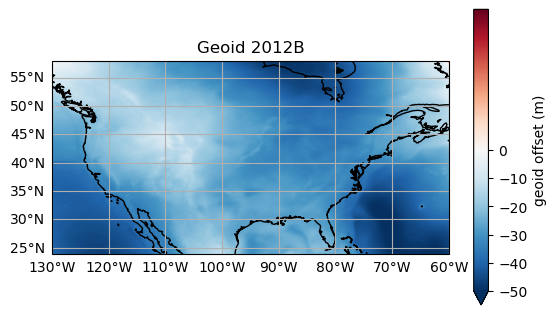

In [17]:
divnorm=colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())

da_2012u.plot.pcolormesh(ax=ax, norm=divnorm, cmap='RdBu_r',
                         cbar_kwargs=dict(shrink=0.8, label='geoid offset (m)'))


ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.legend() # crashes... probably need to do it manually...
plt.title('Geoid 2012B');


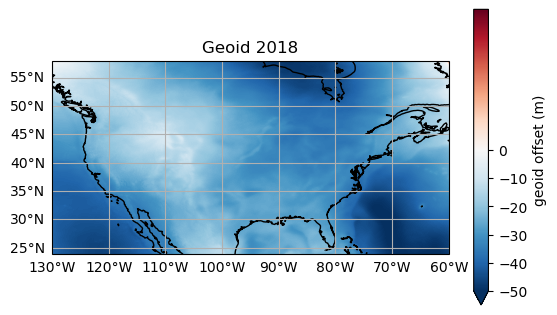

In [18]:
divnorm=colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())

da_2018u.plot.pcolormesh(ax=ax, norm=divnorm, cmap='RdBu_r',
                         cbar_kwargs=dict(shrink=0.8, label='geoid offset (m)'))


ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.legend() # crashes... probably need to do it manually...
plt.title('Geoid 2018');


In [19]:

da_2012u = da_2012u.assign_coords(da_2018u.coords)
diff = da_2018u - da_2012u

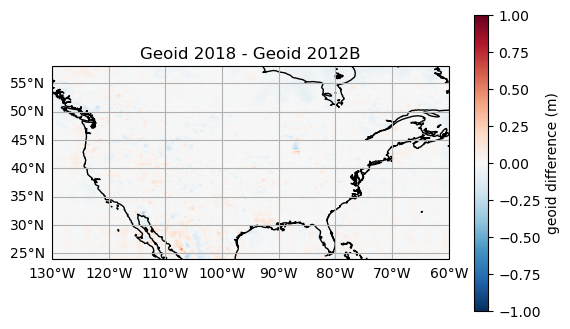

In [24]:
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

ax = plt.axes(projection=ccrs.PlateCarree())

diff.plot.pcolormesh(ax=ax, norm=divnorm, cmap='RdBu_r',
                         cbar_kwargs=dict(shrink=0.8, label='geoid difference (m)'))


ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.legend() # crashes... probably need to do it manually...
plt.title('Geoid 2018 - Geoid 2012B');


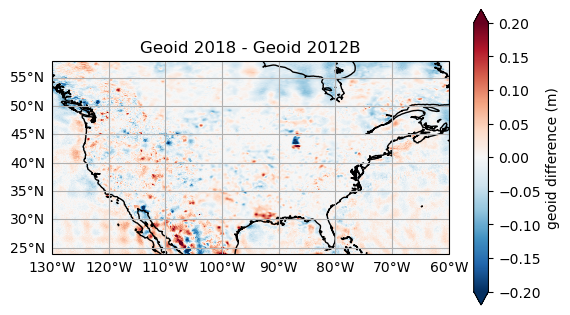

In [25]:
divnorm=colors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=0.2)

ax = plt.axes(projection=ccrs.PlateCarree())

diff.plot.pcolormesh(ax=ax, norm=divnorm, cmap='RdBu_r',
                         cbar_kwargs=dict(shrink=0.8, label='geoid difference (m)'))


ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.legend() # crashes... probably need to do it manually...
plt.title('Geoid 2018 - Geoid 2012B');


## Given the offset between Geoid_2018 and Geoid_2012B (or A), should we provide a custom proj pipeline where we enforce the G2012B as the geoid during reprojection?